https://data-flair.training/blogs/python-mini-project-speech-emotion-recognition/

In [193]:
#pip install numpy scikit-learn librosa soundfile pyaudio 

In [194]:
from IPython import get_ipython;   
get_ipython().magic('reset -sf')

In [195]:
import librosa
import pandas as pd
import soundfile 
import os, glob, pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report

import warnings

#Ignore warnings
warnings.filterwarnings('ignore') 

In [196]:
# Set the seed for reproducibility
SEED = 80
random.seed(SEED)
np.random.seed(SEED)

In [197]:
#DataFlair - Extract features (mfcc, chroma, mel) from a sound file
def extract_feature(file_name, mfcc, chroma, mel):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate=sound_file.samplerate
        if chroma:
            stft=np.abs(librosa.stft(X))
        result=np.array([])
        if mfcc:
            mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result=np.hstack((result, mfccs))
        if chroma:
            chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result=np.hstack((result, chroma))
        if mel:
            #mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
            mel=np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T,axis=0)
            result=np.hstack((result, mel))
    return result

In [198]:
#DataFlair - Emotions in the RAVDESS dataset
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}
#DataFlair - Emotions to observe
observed_emotions=['calm', 'happy', 'fearful', 'disgust']

In [199]:
#DataFlair - Load the data and extract features for each sound file
def load_data(test_size=0.2):
    x,y=[],[]
    for file in glob.glob(".\\01-speech-emotion-data\\Actor_*\\*.wav"):
        file_name=os.path.basename(file)
        emotion=emotions[file_name.split("-")[2]]
        if emotion not in observed_emotions:
            continue
        feature=extract_feature(file, mfcc=True, chroma=True, mel=True)
        x.append(feature)
        y.append(emotion)
    return train_test_split(np.array(x), y, test_size=test_size, random_state=9)  

In [200]:
%%time

#DataFlair - Split the dataset
x_train,x_test,y_train,y_test=load_data(test_size=0.25)

CPU times: total: 29.7 s
Wall time: 20.1 s


In [201]:
#DataFlair - Get the shape of the training and testing datasets
print((x_train.shape[0], x_test.shape[0]))

(576, 192)


In [202]:
#DataFlair - Get the number of features extracted
print(f'Features extracted: {x_train.shape[1]}')

Features extracted: 180


In [203]:
#3 Chek dataset balance 
emotion_counts = pd.Series(y_train).value_counts()
print(emotion_counts)

fearful    155
disgust    144
happy      142
calm       135
Name: count, dtype: int64


In [204]:
# Function to plot spectrograms
def plot_spectrogram(data, emotion, sr=22050):
    plt.figure(figsize=(10, 4))
    S = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128)
    S_DB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_DB, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Spectrogram for {emotion}')
    plt.tight_layout()
    plt.show()


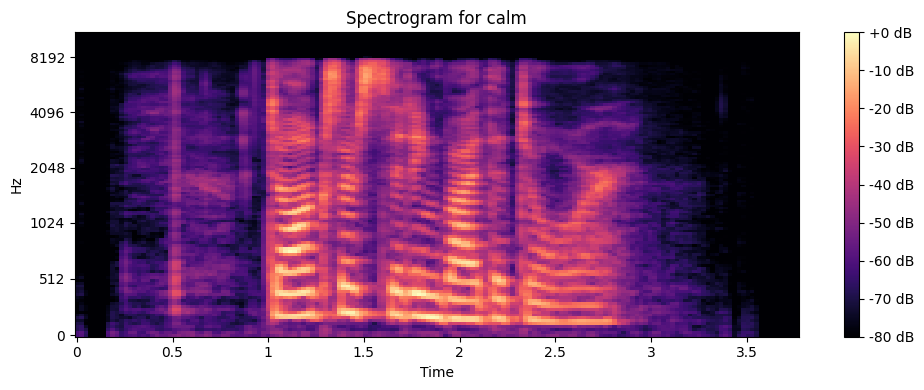

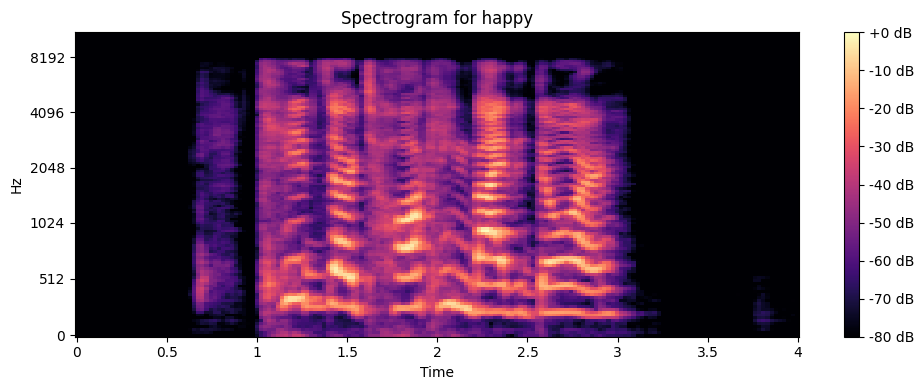

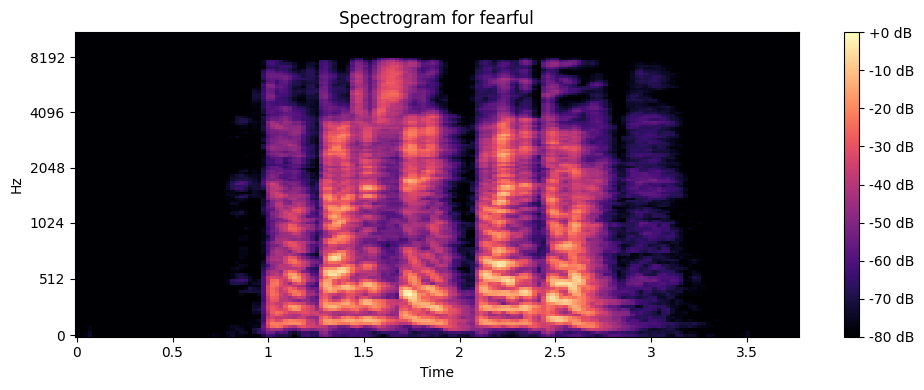

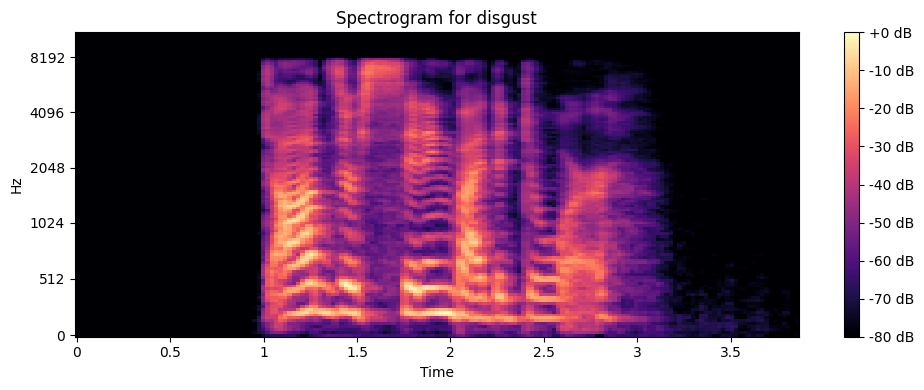

In [205]:
#Select a random file for each observed emotion and plot the spectrogram
for emotion in observed_emotions:
    # Find files corresponding to the emotion
    files = [file for file in glob.glob("./01-speech-emotion-data/Actor_*/*.wav") if emotions[os.path.basename(file).split("-")[2]] == emotion]
    
    if files:
        # Select a random file
        file_path = np.random.choice(files)
        
        # Load the audio file
        y, sr = librosa.load(file_path)
        
        # Plot the spectogram
        plot_spectrogram(y, emotion)

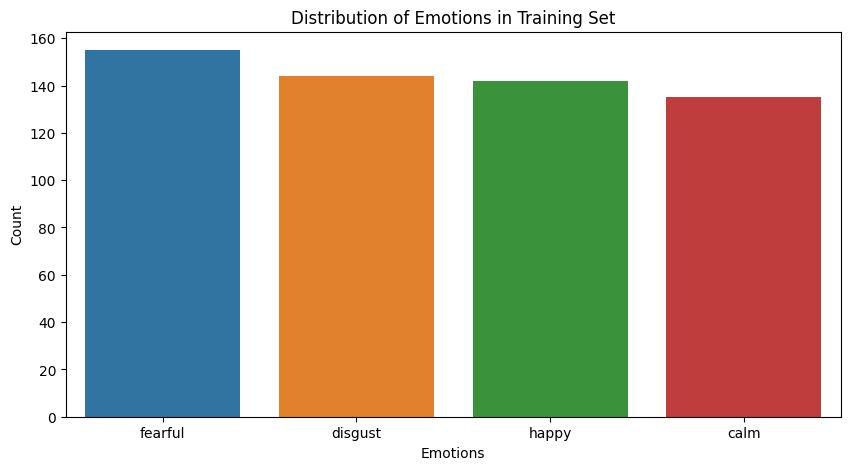

In [206]:
#3 Visualize emotions distribution 
plt.figure(figsize=(10, 5))
sns.barplot(x=emotion_counts.index, y=emotion_counts.values)
plt.title('Distribution of Emotions in Training Set')
plt.xlabel('Emotions')
plt.ylabel('Count')
plt.show()

In [207]:
# Gridsearch parameters
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (150,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.001, 0.05],
    'learning_rate': ['constant', 'adaptive'],
}

In [208]:
#DataFlair - Initialize the Multi Layer Perceptron Classifier
model=MLPClassifier(alpha=0.001, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(500,), learning_rate='adaptive', max_iter=500)

In [209]:
#3 Creating a GridSearchCV object
clf = GridSearchCV(model, param_grid, n_jobs=-1, cv=5)

In [210]:
# Fitting the model with clf
clf.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=MLPClassifier(alpha=0.001, batch_size=256,
                                     hidden_layer_sizes=(500,),
                                     learning_rate='adaptive', max_iter=500),
             n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'], 'alpha': [0.001, 0.05],
                         'hidden_layer_sizes': [(50,), (100,), (150,)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['sgd', 'adam']})

In [211]:
# Printing best parameter found.
print('Best parameters found:\n', clf.best_params_)

Best parameters found:
 {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (150,), 'learning_rate': 'constant', 'solver': 'adam'}


In [212]:
#Obtaining the best parameter found. 
best_model = clf.best_estimator_

In [213]:
#Cross validation before smote
cross_val_scores = cross_val_score(best_model, x_train, y_train, cv=5)
print(f'Cross-validation scores: {cross_val_scores}')
print(f'Mean cross-validation score: {cross_val_scores.mean()}')

Cross-validation scores: [0.75       0.73043478 0.73913043 0.77391304 0.77391304]
Mean cross-validation score: 0.7534782608695652


In [214]:
# Evulate the model
grid_predictions = best_model.predict(x_test)
print("Report without SMOTE:")
print(classification_report(y_test, grid_predictions))

Report without SMOTE:
              precision    recall  f1-score   support

        calm       0.92      0.82      0.87        57
     disgust       0.78      0.79      0.78        48
     fearful       0.67      0.84      0.75        37
       happy       0.78      0.72      0.75        50

    accuracy                           0.79       192
   macro avg       0.79      0.79      0.79       192
weighted avg       0.80      0.79      0.79       192



In [215]:
# Apply SMOTE to the training set
smote = SMOTE(random_state=80)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

In [216]:
# Verify distribution after applying SMOTE
resampled_counts = pd.Series(y_train_resampled).value_counts()
print(resampled_counts)

disgust    155
fearful    155
calm       155
happy      155
Name: count, dtype: int64


In [217]:
#3 Fitting the model with clf
clf.fit(x_train_resampled, y_train_resampled)

GridSearchCV(cv=5,
             estimator=MLPClassifier(alpha=0.001, batch_size=256,
                                     hidden_layer_sizes=(500,),
                                     learning_rate='adaptive', max_iter=500),
             n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'], 'alpha': [0.001, 0.05],
                         'hidden_layer_sizes': [(50,), (100,), (150,)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['sgd', 'adam']})

In [218]:
# Get the best model
best_model_smote = clf.best_estimator_

In [219]:
# Cross validation after smote 
cross_val_scores_smote = cross_val_score(best_model_smote, x_train_resampled, y_train_resampled, cv=5)
print(f'Cross-validation scores: {cross_val_scores_smote}')
print(f'Mean cross-validation score: {cross_val_scores_smote.mean()}')

Cross-validation scores: [0.75806452 0.79032258 0.75806452 0.76612903 0.86290323]
Mean cross-validation score: 0.7870967741935484


In [220]:
# Evaluate the model after using SMOTE

grid_predictions_smote = best_model_smote.predict(x_test)
print("Report with SMOTE:")
print(classification_report(y_test, grid_predictions_smote))

Reporte de clasificación con SMOTE:
              precision    recall  f1-score   support

        calm       0.85      0.82      0.84        57
     disgust       0.80      0.75      0.77        48
     fearful       0.72      0.84      0.78        37
       happy       0.80      0.78      0.79        50

    accuracy                           0.80       192
   macro avg       0.79      0.80      0.79       192
weighted avg       0.80      0.80      0.80       192



In [221]:
# predicting with the best model
y_pred = clf.predict(x_test)

In [222]:
# Printing accuracy 
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy with optimized hyperparameters: {accuracy}')

Accuracy with optimized hyperparameters: 0.796875


In [223]:
# DataFlair - Calculating accuracy 
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
# DataFlair - printing accuracy 
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 79.69%


In [228]:
import joblib

# saving the model
joblib.dump(clf, ".\\01-speech-emotion-data\\Models\\model.pkl") 

['.\\01-speech-emotion-data\\Models\\model.pkl']

In [229]:
import joblib

# testing the model
clf = joblib.load(".\\01-speech-emotion-data\\Models\\model.pkl")

clf.predict(x_test)

array(['happy', 'fearful', 'happy', 'happy', 'fearful', 'calm', 'calm',
       'happy', 'disgust', 'happy', 'happy', 'calm', 'fearful', 'happy',
       'disgust', 'happy', 'calm', 'happy', 'disgust', 'disgust',
       'disgust', 'disgust', 'disgust', 'calm', 'happy', 'happy',
       'disgust', 'happy', 'fearful', 'fearful', 'happy', 'disgust',
       'happy', 'fearful', 'happy', 'calm', 'calm', 'fearful', 'calm',
       'disgust', 'happy', 'calm', 'calm', 'calm', 'fearful', 'disgust',
       'disgust', 'calm', 'calm', 'happy', 'fearful', 'fearful',
       'fearful', 'fearful', 'disgust', 'fearful', 'disgust', 'happy',
       'calm', 'calm', 'disgust', 'calm', 'happy', 'calm', 'disgust',
       'calm', 'calm', 'disgust', 'disgust', 'happy', 'fearful',
       'fearful', 'fearful', 'fearful', 'fearful', 'disgust', 'fearful',
       'happy', 'calm', 'fearful', 'disgust', 'calm', 'fearful', 'calm',
       'disgust', 'calm', 'disgust', 'happy', 'happy', 'fearful',
       'disgust', 'disgust'